In [8]:
import numpy as np
import scipy
import itertools

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts
matplotlib.rcParams['mathtext.fontset'] ='stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.weight"] = "bold"

In [10]:
import cudaq
from cudaq import spin
from Sampling_Circuits import *

In [11]:
def Euler_angle_decomposition(U:np.ndarray):
    theta = 2 * np.arccos(np.abs(U[0, 0]))

    phi = np.angle(U[1, 0]) - np.angle(U[0, 0])
    lam = np.angle(U[1, 1]) - np.angle(U[1, 0])
    
    return theta, phi, lam

from scipy.stats import unitary_group
unitary_matrix = unitary_group.rvs(2)

#print(Euler_angle_decomposition_old(unitary_matrix))
print(Euler_angle_decomposition(unitary_matrix))

(0.9212669514625965, -0.2869926859188241, -1.8298681851153815)


In [56]:
class All_proposals:
    def __init__(self,**kwargs):
        self.beta= kwargs['inverse_temp']
        if self.beta is None:
            raise TypeError('Temperature T is undefined.')
        if self.beta < 0:
            raise ValueError('Temperature T cannot be negative.')

        # For model instance below, use the H(v) function. This H(v) appears inside the fitted
        #proxy distribution phi(v) which is phi(v)=e^-H(v)/Z.... H(v) = \sum_i h_i v_i + \sum_{ij} Q_ij v_i v_j
        #I shall refer to h_i as one-body terms passed as a list of length(n) and Q_ij as two body terms
        #passed as a list of length(n^2) with i index changing faster than j index. Note h_i and Q_ij are always real

        #assert kwargs['one_body_coeffs'].any != None, "Please provide one-body coeffs from the fitted distribution phi(v)"  #This is the one-body term within the Ham of phi(v). This is a function of all RBM model params
        #assert kwargs['two_body_coeffs'] != None, "Please provide two-body coeffs from the fitted distribution phi(v)"  #This is the two-body term within the Ham of phi(v). This is a function of all RBM model params

        self.no_spins = len(kwargs['one_body_coeffs'])

        self.model_instance_one_body = kwargs['one_body_coeffs']

        self.model_instance_two_body  =  np.reshape(np.array(kwargs['two_body_coeffs']), (self.no_spins, self.no_spins), order='F')


    def get_energy_array(self):
        self.Energy_array = np.zeros(2**self.no_spins)

        for num in np.arange(2**self.no_spins):
             config = self.get_int_to_spinconfig(num, self.no_spins)
             #print(config)
             self.Energy_array[num] = np.dot(config, np.dot(self.model_instance_two_body, config)) + np.dot(config,self.model_instance_one_body)
        return self


    def Learner_Ham_maker_w_wo_mixer(self, gamma:float, alpha:float, type_of_Ham="with_mixer"): #Technically not required, only useful if prop of H(v) is studied
        Ham=0
        import itertools
        #This makes the full learner Ham with mixer i.e. (1-gamma)*alpha*H_z + gamma*H_x  or without mixer where we just have H_z
        # where H_z = H(v) = \sum_i h_i v_i + \sum_{ij} Q_ij v_i v_j with v_i replaced with sigma_z
        #H_x = mixer = \sum_i X_i
        #alpha is the norm ratio of ||H_x||_F/||H_z||_F
        #gamma is unif(gamma1, gamma2). The paper says gamma1 as 0.2 and gamma2 as 0.6
        #CAUTION - USE this function for SMALL qubit size (n) ONLY as it involves exp storage of matrix size 2**n * 2**n when converted to np.array.
        # As a SparsePaulilist object, as I have defined below, it is fine to use it even for higher number of qubits

        for qubit_tuple in list(itertools.combinations(np.arange(self.no_spins),r=2)):
            #print(qubit_tuple)
            # Qiskit follows endian order with least sig bit as qubit[0] which is why we have (no_spins-1-index)
            coef = (1-gamma)*alpha*(self.model_instance_two_body[self.no_spins-1-qubit_tuple[0], self.no_spins-1-qubit_tuple[1]])
            Ham += coef * spin.z(qubit_tuple[0])*spin.z(qubit_tuple[1])  
                                
        for qubit_index in np.arange(self.no_spins):
            # Qiskit follows endian order with least sig bit as qubit[0] which is why we have (no_spins-1-index)
            coef = -(1-gamma)*alpha*self.model_instance_one_body[self.no_spins-1-qubit_index]
            Ham += coef * spin.z(qubit_index)
            
            if type_of_Ham == "with_mixer":
                Ham += gamma * spin.x(qubit_index)

        self.Learner_Ham_w_wo_mixer = Ham
        return self


    def computing_norm_ratio(self):  #This gives value of alpha = self.computing_norm_ratio()
        #This computes alpha = ||H_x||_F/||H_z||_F using params only. No storing and computing full matrix is necessary
        #Coupling_matrix = np.reshape(np.array(self.model_instance_two_body), (self.no_spins, self.no_spins), order='F')
        alpha = np.sqrt(self.no_spins)/np.sqrt(sum([J**2 for J in self.model_instance_two_body[np.tril_indices(self.no_spins, k = -1)]]) + sum([h**2 for h in self.model_instance_one_body]))
        return alpha


    def scalar_gamma_sampling(self, gamma_limits:tuple=(0.25,0.6), seed=10, sampling_type="continuous"):
        # This function samples the scalar gamma for defining the unitary U(t, gamma)
        if sampling_type == "continuous":
            np.random.seed(seed)
            gamma = np.random.uniform(gamma_limits[0], gamma_limits[1], 1)[0]
            return gamma
        else:
            gamma_steps = 30 # approximate integral over by Riemann sum
            gamma_start_array, gamma_step_size = np.linspace(gamma_limits[0], gamma_limits[1], num=gamma_steps, endpoint=False, retstep=True)
            gamma_midpt_array = gamma_start_array + gamma_step_size/2
            return gamma_midpt_array, gamma_step_size


    def scalar_time_sampling(self, time_limits:tuple=(4,20), seed=10, time_delta=0.5, sampling_type="continuous"):
        # This function samples the scalar time t for defining the unitary U(t, gamma)
        if sampling_type == "continuous":
            np.random.seed(seed)
            time = np.random.uniform(time_limits[0], time_limits[1], 1)[0]
            return time
        else:
            low_stop = np.ceil(time_limits[0]/time_delta)
            high_stop = np.ceil(time_limits[1]/time_delta) + 1
            time_array = [np.round(r*time_delta,4) for r in np.arange(low_stop, high_stop,1)]
            return time_array, time_delta



    def get_quantum_circuit_proposal_matrix(self, mode="Exact-no Trotter error/no Sampling error"):
        # This function creates the entire proposal distribution matrix Q(s'|s) from the quantum circuit
        alpha = self.computing_norm_ratio()
        #time_array, time_delta_step = self.scalar_time_sampling(sampling_type="discrete")
        time_delta_step = 0.5
        #gamma_array, gamma_step = self.scalar_gamma_sampling(sampling_type="discrete")

        gamma = 0.42
        time = 12
        if mode == "Exact-no Trotter error/no Sampling error":
            self.Learner_Ham_maker_w_wo_mixer(gamma, alpha, type_of_Ham="with_mixer")
            full_Ham_mat = self.Learner_Ham_w_wo_mixer.to_matrix()
            U_t = scipy.linalg.expm(np.multiply(-1.0j*time, full_Ham_mat))

        # Getting matrix out of circuit feature is not yet available on CudaQ

        '''if mode == "Trotter error/no Sampling error":
            circuit = self.Trotter_circuit(Trotter_repeat_length=int(time/time_delta_step), alpha=alpha,
                                           gamma=gamma,time_delta=time_delta_step,initial_config=None)
            import qiskit.quantum_info as qi
            U_t = qi.Operator(circuit) '''

        Proposal_mat =  np.multiply(np.conjugate(U_t), U_t)

        return Proposal_mat


    def get_uniform_proposal_matrix(self):
        #Creates a uniform proposal matrix as np.array where the transition prob from s to s' i..e P(s'|s)=1/2^n for all s and s' pair
        Proposal_mat = np.multiply(1.0/2**(self.no_spins), np.ones((2**(self.no_spins), 2**(self.no_spins))))
        return Proposal_mat


    def get_local_proposal_matrix(self):
         #Creates a proposal matrix as np.array wherein a spin is chosen at random and flipped.
        #This is local proposal flipping responsible for generating configs with close by hamming dists

        Sum_Pauli_x = 0
        for qubit_index in np.arange((self.no_spins)):
            Sum_Pauli_x += spin.x(qubit_index)

        Proposal_mat = np.multiply(1.0/self.no_spins, Sum_Pauli_x.to_matrix())
        return Proposal_mat


    def get_Haar_random_proposal_matrix(self):
        #Generate a Haar-random matrix using the QR decomposition of an arbitrary complex mattrix with entries from std Gaussian dist (0,1).
        Arb_complex_mat = np.random.normal(0,1.0,size=(2**self.no_spins, 2**self.no_spins)) + 1.0j*np.random.normal(0,1.0,size=(2**self.no_spins, 2**self.no_spins))
        Q, R = np.linalg.qr(Arb_complex_mat)
        New_lam_matrix = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(2**self.no_spins)])
        Proposal_mat = np.real(np.multiply(np.conjugate(np.dot(Q, New_lam_matrix)), np.dot(Q, New_lam_matrix)))
        return Proposal_mat


    def get_transition_matrix_from_proposal(self, Proposal_mat, acceptance_criteria='metropolis'):
        # This function gets the full transition matrix P(s'|s) = Q(s'|s) * Acceptance(s'|s) where Q(s'|s)
        #can be a quantum circuit proposal, a local flip proposal, uniform proposal or Haar random proposal
        import math
        E_rowstack = np.tile(self.Energy_array, (2**self.no_spins,1))  # E_rowstack[i,j] = E_j for all i
        E_diff = E_rowstack.T - E_rowstack # E_diff[i,j] = E_i - E_j (new E minus old E)

        uphill_moves = (E_diff >= 0) # includes isoenergetic moves
        downhill_moves = np.invert(uphill_moves)

        if acceptance_criteria =='metropolis':
            if self.beta > 0:
                A_s_sp = np.exp(-E_diff*self.beta, where=uphill_moves, out=np.ones_like(E_diff)) #only compute exp for uphill moves, downhill ones are filled with 1 anyway
            if self.beta == math.inf:
            # reject all uphill, accept all others (level and downhill)
                A_s_sp = np.where(uphill_moves, 0.0, 1.)

        Transition_mat = np.multiply(A_s_sp, Proposal_mat)  #note not np.dot but elem wise multiplication
        np.fill_diagonal(Transition_mat, 0)
        diag = np.ones(2**self.no_spins) - np.sum(Transition_mat, axis=0) # This step just fills the diag elems with 1-row_sum. This ensures that row_sum=1 for Transition mat
        Transition_mat = Transition_mat + np.diag(diag)
        return Transition_mat

    ''' We don't need to store transition matrix to generate trajectories. But it proves to be more efficient when working on a classical simulator as it stores all the possible transitions at once, instead of running quantum circuit multiple times.'''
    def generate_MCMC_trajectories(self, init_config:np.ndarray, transition_matrix=[]):
        if len(transition_matrix) == 0: 
            N = self.no_spins
            alpha = self.computing_norm_ratio()
            #time_array, time_delta_step = self.scalar_time_sampling(sampling_type="discrete")
            time_delta = 0.5
            #gamma_array, gamma_step = self.scalar_gamma_sampling(sampling_type="discrete")
            gamma = 0.42
            time = 12

            k=int(time/time_delta)

            l = self.model_instance_one_body
            J = np.reshape(self.model_instance_two_body, -1)

            angle_list = []
            for qubit in range(N):
                coeff = -alpha*(1-gamma)*l[N-1-qubit]
                one_body_Ham = gamma * spin.x(0) + coeff * spin.z(0)
                angle_list.append(list(Euler_angle_decomposition(scipy.linalg.expm(-1.0j*time_delta*one_body_Ham.to_matrix()))))   # always 2*2 so no problem of exponentiation, storage

            theta = np.zeros(N)
            phi = np.zeros(N)
            lam = np.zeros(N)
            for qubit in range(N):
                theta[qubit], phi[qubit], lam[qubit] = angle_list[qubit]

            counts = cudaq.sample(Trotter_circuit, N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)
            #counts = Trotter_circuit_builder(N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)
            
            for key, value in counts.items():
                if value == 1: 
                    final_config = key

            res = [1.0 if s == '1' else -1.0 for s in final_config]
            
            return np.array(res)

        else: 
            number_starting_config = self.get_spinconfig_to_int(init_config)
            #This function given a transition matrix (local, uniform, quantum, Haar) anything..can choose a configuration with the prob given along rows of transition matrix
            number_chosen = np.random.choice(np.arange(2**self.no_spins), p=transition_matrix[:,number_starting_config])
            return self.get_int_to_spinconfig(number_chosen, self.no_spins)
    


    def get_abs_spectral_gap_from_transition_mat(self, Transition_mat):
        #Returns the absolute spectral gap of transition_mat

        dist = np.sort(1-np.abs(scipy.linalg.eigvals(Transition_mat)))
        delta = np.min(dist[1:])

        return delta

    def get_int_to_spinconfig(self, number:int, n:int):
        # Let i be the input for number entry above. This number is between 0 to 2^(n)-1 where n is the positive integer power deciding the number of slots in the binary rep of i
        # The output of this function will be [1,-1]^n which will be achieved by converting i to binary first and replacing every 0 bit with -1
        #Thus if i=0 === [-1,-1,-1....-1_n]
        #        i=1 === [-1,-1,-1....1_n]   # least sig bit flipped to 1
        #      i=2^n -1 == [1,1,1....1_n]    # all bits flipped
        if number < 0 or number > (2**n-1):
            raise ValueError('number out of range')

        bin_list = list( np.binary_repr(number,n))
        return np.array([-1 if bit=='0' else 1 for bit in bin_list])


    def get_spinconfig_to_int(self, spinconfig:np.ndarray):
        #The inverse of int_to_spinconfig. Example: if spinconfig is int(np.array([-1,-1,1])) then output is 1. Given a config it first
        # undo the array as -1 is changed to 0 and 1 is left alone.
        bit_string = ''.join(['0' if spin==-1 else '1' for spin in spinconfig])
        return int(bit_string, 2)  #the base is binary hence 2


    def get_hamming_dist(self,spinconfig1:np.ndarray,spinconfig2:np.ndarray):
        #config1 and config2 will have to have same number of slots n
        #Computes the Hamming distance between the binary representations of configs given . They are first converted to integers
        int1 = self.get_spinconfig_to_int(spinconfig1)
        int2 = self.get_spinconfig_to_int(spinconfig2)
        diff_int = np.bitwise_xor(int1, int2)
        diff_bin = [int(bit) for bit in np.binary_repr(diff_int)]
        return np.sum(diff_bin)

In [57]:
#Builder mode
import itertools

def two_qubit_gate_builder(kernel, angle:float, qubit_1: cudaq.qubit, qubit_2: cudaq.qubit):  # mode: str = "CNOT_decomposition"  [cudaq doesn't support string type]
    # This function provides circuit description of RZZ(theta) - This is the 2-qubit gate used for H_Z
    kernel.cx(qubit_1, qubit_2)
    kernel.rz(angle, qubit_2)
    kernel.cx(qubit_1, qubit_2)

    # if mode == "no_decomposition":   #RZZ is not supported by CudaQ
    #     rzz(angle, qubit_1, qubit_2)

    # if mode == "RZX_decomposition":  #RZX is not supported by CudaQ
    #     h(qubit_2)
    #     rzx(angle, qubit_1, qubit_2)   # can be implemented natively by pulse-stretching
    #     h(qubit_2)


def Trotter_circuit_builder(N: int, k:int, alpha:float,
                    gamma:float, time_delta: float, theta:np.ndarray, phi:np.ndarray, lam:np.ndarray, J:np.ndarray, initial_config: np.ndarray, shots_count: int):  #list[int]
    # This is the actual Trotter circuit. Here the circuit construction for Trotterized version of time evolution happens
    # k : Trotter_repeat_length

    kernel = cudaq.make_kernel()
    qreg = kernel.qalloc(N)

    assert(len(initial_config)==N), "initial config array is not same length as number of spins"
    for i in range(N):
        if initial_config[i] == 1: kernel.x(qreg[i])
                
        #circuit.x(qreg[N-1-np.argwhere(return_array==1).flatten()])  # Qiskit follows endian order with least sig bit as qubit[0] on top which is why we have no_spins-1-index

    for _ in range(k-1):
        for qubit in range(N):
            kernel.u3(theta[qubit], phi[qubit], lam[qubit], qreg[qubit])

        for i in range(N):
            for j in range(i + 1, N): 
                angle = 2*J[(N-1-i)*N + N-1-j]*(1-gamma)*alpha*time_delta
                two_qubit_gate_builder(kernel, angle, qreg[i], qreg[j])

        #circuit.barrier()

    for qubit in range(N):
        kernel.u3(theta[qubit], phi[qubit], lam[qubit], qreg[qubit])

    kernel.mz(qreg)
    return cudaq.sample(kernel, shots_count=shots_count)

In [70]:
@cudaq.kernel
def two_qubit_gate(angle:float, qubit_1: cudaq.qubit, qubit_2: cudaq.qubit):  # mode: str = "CNOT_decomposition"  [cudaq doesn't support string type]
    # This function provides circuit description of RZZ(theta) - This is the 2-qubit gate used for H_Z
    x.ctrl(qubit_1, qubit_2)
    rz(angle, qubit_2)
    x.ctrl(qubit_1, qubit_2)

    # if mode == "no_decomposition":   #RZZ is not supported by CudaQ
    #     rzz(angle, qubit_1, qubit_2)

    # if mode == "RZX_decomposition":  #RZX is not supported by CudaQ
    #     h(qubit_2)
    #     rzx(angle, qubit_1, qubit_2)   # can be implemented natively by pulse-stretching
    #     h(qubit_2)


@cudaq.kernel
def Trotter_circuit(N: int, k:int, alpha:float,
                    gamma:float, time_delta: float, theta:np.ndarray, phi:np.ndarray, lam:np.ndarray, J:np.ndarray, initial_config:np.ndarray):  #list[int]
    # This is the actual Trotter circuit. Here the circuit construction for Trotterized version of time evolution happens
    # k : Trotter repeat length

    qreg=cudaq.qvector(N)

    # assert(len(initial_config)==N), "initial config array is not same length as number of spins"
    for i in range(N):
        if int(initial_config[i]) == 1: x(qreg[i])                
        #circuit.x(qreg[N-1-np.argwhere(return_array==1).flatten()])  # Qiskit follows endian order with least sig bit as qubit[0] on top which is why we have N-1-index
    
    for _ in range(k-1):
        for qubit in range(N):
            u3(theta[qubit], phi[qubit], lam[qubit], qreg[qubit])

        for i in range(N):
            for j in range(i + 1, N): 
                angle = 2*J[(N-1-i)*N + N-1-j]*(1-gamma)*alpha*time_delta
                two_qubit_gate(angle, qreg[i], qreg[j])

    for qubit in range(N):
        u3(theta[qubit], phi[qubit], lam[qubit], qreg[qubit])




In [71]:
N = 4
k=4
J = np.random.randn(N*N)
l = np.random.randn(N)
init_config = np.random.choice([1.0,-1.0], size=N)

alpha = 0.5
gamma = 1.0
time_delta = 0.5

angle_list = []
for qubit in range(N):
    coeff = -alpha*(1-gamma)*l[N-1-qubit]
    one_body_Ham = gamma * spin.x(0) + coeff * spin.z(0)
    angle_list.append(list(Euler_angle_decomposition(scipy.linalg.expm(-1.0j*time_delta*one_body_Ham.to_matrix()))))   # always 2*2 so no problem of exponentiation, storage

theta = np.zeros(N)
phi = np.zeros(N)
lam = np.zeros(N)
for qubit in range(N):
    theta[qubit], phi[qubit], lam[qubit] = angle_list[qubit]


In [72]:
counts = cudaq.sample(Trotter_circuit, N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1000)

count_build = Trotter_circuit_builder(N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1000)


<BarContainer object of 16 artists>

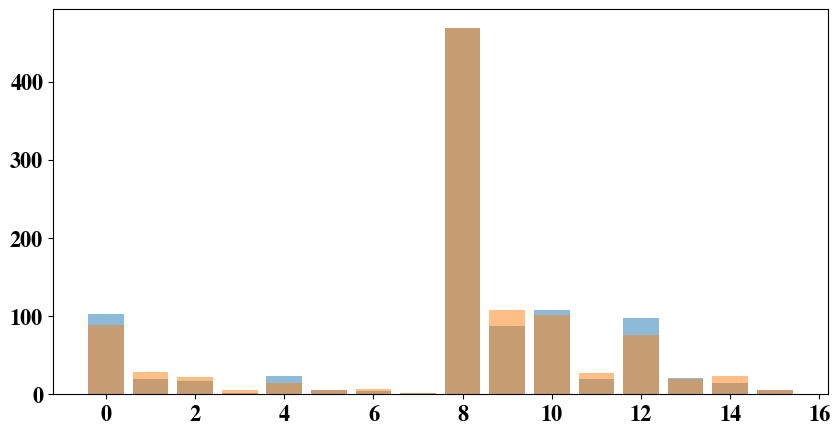

In [73]:
plt.figure(figsize=(10, 5))

bitstrings = []
frequencies = []

for key, value in counts.items():  # CUDA-Q result is an iterable
    bitstrings.append(int(key,2))
    frequencies.append(value)

plt.bar(bitstrings, frequencies, alpha=0.5)
#plt.show()

#plt.figure(figsize=(10, 5))
bitstrings = []
frequencies = []

for key, value in count_build.items():  # CUDA-Q result is an iterable
    bitstrings.append(int(key,2))
    frequencies.append(value)

plt.bar(bitstrings, frequencies,alpha=0.5)



In [75]:
# for key, value in counts.items():
#     print(key,value)

In [64]:
def get_operator(kernel):
    num_qubits = 2
    N = 2**num_qubits
    U = np.zeros((N, N), dtype=np.complex128)
    params = [1 ,2]

    for j in range(N):
        state_j    = np.zeros((N), dtype=np.complex128)
        state_j[j] = 1.0
        U[:, j] = np.array(cudaq.get_state(kernel, params, state_j), copy=False)
    print(U)

#get_operator()

In [65]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

alpha = Proposal_object.computing_norm_ratio()
#time_array, time_delta_step = self.scalar_time_sampling(sampling_type="discrete")
time_delta_step = 0.5
#gamma_array, gamma_step = self.scalar_gamma_sampling(sampling_type="discrete")
gamma = 0.42
time = 12
    
counts = cudaq.sample(Trotter_circuit, N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)

1.0709543791732428


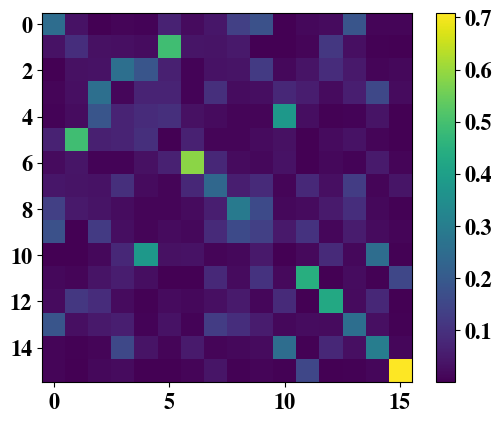

abs spectral gap of quantum T matrix 0.13909005487381298


In [66]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

#print(Proposal_object.model_instance_one_body, Proposal_object.model_instance_two_body)
Proposal_object.get_energy_array().Energy_array

alpha = Proposal_object.computing_norm_ratio()
print(alpha)

#print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="continuous"))
#print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="discrete"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="continuous"))
#print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.2, sampling_type="discrete"))
prop_exact = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error")
#print(prop_exact)

plt.imshow(np.real(prop_exact))
plt.colorbar()
plt.show()

#prop_Trotter = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Trotter error/no Sampling error")
#print(prop_Trotter)
#print("norm diff between exact and Trotter", np.linalg.norm(prop_exact - prop_Trotter))
Transition_mat=Proposal_object.get_transition_matrix_from_proposal(prop_exact, acceptance_criteria='metropolis')
print("abs spectral gap of quantum T matrix",Proposal_object.get_abs_spectral_gap_from_transition_mat(Transition_mat))

[0.77132064 0.02075195 0.63364823 0.74880388] [[0.49850701 0.19695374 0.10100557 0.74114301]
 [0.19695374 0.08833981 0.59877604 0.62263471]
 [0.10100557 0.59877604 0.81262096 0.76515009]
 [0.74114301 0.62263471 0.76515009 0.71457578]]


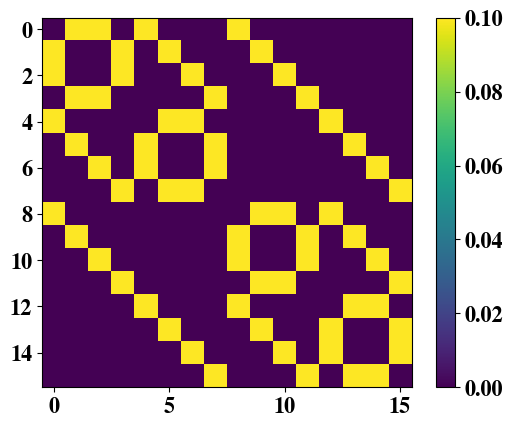

1.0709543791732428
E_array [ 5.99084519 -1.02725831  1.39841486  0.50151211  0.35889113 -1.67813471
  0.55666912  4.64084404  3.37707719  2.28811781 -0.40730862  4.62493275
 -0.67924694  3.21287134  0.32657558 10.33989461]
(0.7997720916201615, -1.5285178425412336, 1.6130748110485595)


In [67]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

print(Proposal_object.model_instance_one_body, Proposal_object.model_instance_two_body)

H = Proposal_object.Learner_Ham_maker_w_wo_mixer(gamma=0.1, alpha=5.0, type_of_Ham="with_mixer").Learner_Ham_w_wo_mixer
H = np.array(H.to_matrix())
np.fill_diagonal(H, 0)

plt.imshow(np.real(H))
plt.colorbar()
plt.show()

alpha = Proposal_object.computing_norm_ratio()
print(alpha)
# print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="continuous"))
# print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="discrete"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="continuous"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="discrete"))

print("E_array",Proposal_object.get_energy_array().Energy_array)

mat = 0.5 * spin.x(0) + 0.05 * spin.z(0)
mat = np.array(mat.to_matrix())
print(Euler_angle_decomposition(scipy.linalg.expm(-1.0j*0.8*mat)))

#circuit = Proposal_object.Trotter_circuit(Trotter_repeat_length=6, alpha=alpha, gamma=0.1, time_delta=0.8, initial_config=None)
# circuit = QuantumCircuit(5, 1)
# circuit = Proposal_object.two_qubit_gate(circuit, angle=0.1, qubit_1=2, qubit_2=4, mode="CNOT_decomposition")
#circuit.draw("mpl")
Local_prop=Proposal_object.get_local_proposal_matrix()
#print(Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error"))
#print(Proposal_object.get_Haar_random_proposal_matrix())
# print(Proposal_object.get_int_to_spinconfig(2,4))
# print(Proposal_object.get_spinconfig_to_int([1,-1,1,-1]))
# print(Proposal_object.get_hamming_dist([1,-1,1,-1], [1,-1,-1,-1]))
# print(Proposal_object.get_transition_matrix_from_proposal(Local_prop, acceptance_criteria='metropolis'))

In [68]:
init_config = np.random.choice([1.0,-1.0], size=N)
final_conf = Proposal_object.generate_MCMC_trajectories(init_config)

In [69]:
final_conf

array([-1., -1., -1.,  1.])